In [1]:
from utils import read_data

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
import os
import pprint

### Step 0 - Prepare the Data

#### 0.1 - set working directory

In [4]:
# get your current working diectory
cwd = os.getcwd()

In [5]:
# The parameters for system operations
checkpoint_dir = "checkpoint"  # Name of checkpoint directory
sample_dir = "sample"          # Name of sample directory

In [6]:
# make the 'checkpoint' directory
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
# # make the 'sample' directory
# if not os.path.exists(sample_dir):
#     os.makedirs(sample_dir)

In [7]:
# get your diectorry contains testing and training data
wd_train = os.path.join(cwd, checkpoint_dir, 'train.h5')
wd_test = os.path.join(cwd, checkpoint_dir, 'test.h5')

#### 0.2 - helper functin for feeding data

In [8]:
class BatchFeeder():
    
    def __init__(self, wd_train, wd_test):
        # indicator of the batches
        self.i = 0
        # initialize the training data
        self.training_lr, self.training_hr = read_data(wd_train)
        # initialize the testing data
        self.testing_lr, self.testing_hr = read_data(wd_test)
        
    # this part is for data preprocessing
    # as we already use processed data, we write nothing here
    def set_up_images(self):
        pass
        
    def next_batch(self, batch_size):
        
        lr = self.training_lr[self.i:self.i+batch_size]
        hr = self.training_hr[self.i:self.i+batch_size]
        self.i = (self.i+batch_size) % len(self.training_hr)
        
        return lr, hr

#### 0.3 - get some senses of data we will work with

In [9]:
bf = BatchFeeder(wd_train, wd_test)
bf.set_up_images()

In [10]:
# please do check the diminsion of data
# low resolution image has already been augmented by bicubic maybe
# more details in utils.py
bf.training_lr.shape

(21884, 33, 33, 1)

In [11]:
bf.training_hr.shape

(21884, 21, 21, 1)

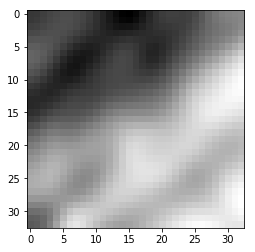

In [12]:
plt.imshow(bf.training_lr[0].reshape(33,33), cmap='gist_gray')

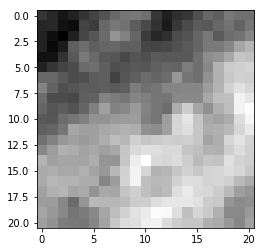

In [13]:
plt.imshow(bf.training_hr[0].reshape(21,21), cmap='gist_gray')

### Step 1 - Creating the Model

In [14]:
# True for training, False for testing purpose
is_train = True
# The size of scale factor for preprocessing input image
scale = 3

#### 1.1 - Initialize the parameters

In [15]:
# The hyperparameters for learning
epoch = 1000 
batch_size = 128
learning_rate = 1e-4

In [16]:
# The hyperparameters for convolutions
image_size = 33  # The size of image to use
label_size = 21  # The size of label to produce
c_dim = 1        # Dimension of image color
stride = 14      # The size of stride to apply input image

#### 1.2 - placeholders

In [17]:
# images are training data set
lr = tf.placeholder(tf.float32, [None, image_size, image_size, c_dim], name='lr')
hr = tf.placeholder(tf.float32, [None, label_size, label_size, c_dim], name='hr')

#### 1.3 - parameters/filters

In [18]:
W1 = tf.Variable(tf.random_normal([9, 9, 1, 64], stddev=1e-3), name='W1')
b1 = tf.Variable(tf.zeros([64]), name='b1')
W2 = tf.Variable(tf.random_normal([1, 1, 64, 32], stddev=1e-3), name='W2')
b2 = tf.Variable(tf.zeros([32]), name='b2')
W3 = tf.Variable(tf.random_normal([5, 5, 32, 1], stddev=1e-3), name='W3')
b3 = tf.Variable(tf.zeros([1]), name='b3')

#### 1.4 - layers

In [19]:
# patch extraction and representation
conv1 = tf.nn.relu(tf.nn.conv2d(lr, 
                                W1, strides=[1,1,1,1], padding='VALID') + b1)

# non-linear mapping
conv2 = tf.nn.relu(tf.nn.conv2d(conv1,
                                W2, strides=[1,1,1,1], padding='VALID') + b2)

# reconstruction
hr_pred = tf.nn.conv2d(conv2, W3, strides=[1,1,1,1], padding='VALID') + b3

#### 1.5 - loss functions

In [20]:
# here, we use mse as loss function for simplicity
loss = tf.reduce_mean(tf.squared_difference(hr_pred, hr))

#### 1.6 - Optimizer

In [21]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
train = optimizer.minimize(loss)

### Step 2 - Training the Model

#### 2.1 - initializer

In [22]:
init = tf.global_variables_initializer()

#### 2.2 - graph session

In [23]:
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())

    for i in range(epoch):
        batch = bf.next_batch(batch_size)
        sess.run(train, feed_dict={lr: batch[0], hr: batch[1]})
        
        # PRINT OUT A MESSAGE EVERY 100 STEPS
        if i%100 == 0:
            
            print('Currently on step {}'.format(i))
            print('Testing accuracy is {}: '.format(sess.run(loss, feed_dict={lr:bf.testing_lr, hr:bf.testing_hr})))
            print('Training  accuracy is {}: '.format(sess.run(loss, feed_dict={lr:batch[0], hr:batch[1]})))
            print('\n')

Currently on step 0
Testing accuracy is 0.3217816948890686: 
Training  accuracy is 0.26777470111846924: 


Currently on step 100
Testing accuracy is 0.31194448471069336: 
Training  accuracy is 0.1993263214826584: 


Currently on step 200
Testing accuracy is 0.3032987117767334: 
Training  accuracy is 0.35916614532470703: 


Currently on step 300
Testing accuracy is 0.2945461869239807: 
Training  accuracy is 0.1767321079969406: 


Currently on step 400
Testing accuracy is 0.2863978445529938: 
Training  accuracy is 0.15123555064201355: 


Currently on step 500
Testing accuracy is 0.2784646451473236: 
Training  accuracy is 0.17303282022476196: 


Currently on step 600
Testing accuracy is 0.27063003182411194: 
Training  accuracy is 0.22549082338809967: 


Currently on step 700
Testing accuracy is 0.2635676860809326: 
Training  accuracy is 0.13571730256080627: 


Currently on step 800
Testing accuracy is 0.2561172544956207: 
Training  accuracy is 0.21407578885555267: 


Currently on step 900